In [1]:
from math import floor 

def discretize(waiting_times):
    return 100000* abs(round(waiting_times[0])) + 1000*abs(round(waiting_times[1])) + 10*abs(round(waiting_times[2]))

In [42]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(1)
                        print("Appending to queue", i)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   reward for clearing list
    elif not any(queues):
        return 25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1

def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time > 9.9:
        waiting_time = 9.9

In [43]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(1000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [0.3, 0.25, 0.4]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        #print(f"WAITING TIMES {np.array(waiting_times)}")
        waiting_times = discretize(observation)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.totaltime = 1
        return [0,0,0]
        
    def render(self):
        pass

In [44]:
env = TrafficGenerator()
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(1000000)
Action space:  Discrete(3)


In [45]:
env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

~~~~~~~~~
chosen 2
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
0
reward -25
~~~~~~~~~
chosen 1
Appending to queue 2
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
0
reward -25
~~~~~~~~~
chosen 1
Appending to queue 0
Appending to queue 1
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
10
reward 1
~~~~~~~~~
chosen 2
Appending to queue 2
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
101000
reward 1
~~~~~~~~~
chosen 1
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
200010
reward -25
~~~~~~~~~
chosen 1
Appending to queue 0

In [46]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters

total_episodes = 400
total_test_episodes = 50
max_steps = 999
learning_rate = 0.1
gamma = 0.618
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

state = env.reset()

# Train
for episode in range(total_episodes):
    total_rewards = 0
    print("Episode ", episode,"/", total_episodes )
    for step in range(max_steps):
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state, :])
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        total_rewards += reward
        print(new_state)
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        state = new_state
        if done: 
            rewardstest.append(total_rewards)
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))




Episode  0 / 400
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Episode  1 / 400
0
Episode  2 / 400
0
Episode  3 / 400
Appending to queue 2
0
Episode  4 / 400
Appending to queue 0
Appending to queue 1
0
Episode  5 / 400
Appending to queue 2
1000
Episode  6 / 400
2010
Episode  7 / 400
Appending to queue 0
3000
Episode  8 / 400
Appending to queue 1
Appending to queue 2
102000
Episode  9 / 400
3010
Episode  10 / 400
Appending to queue 0
Appending to queue 2
4010
Episode  11 / 400
103020
Episode  12 / 400
Appending to queue 1
200030
Episode  13 / 400
Appending to queue 2
300030
Episode  14 / 400
Appending to queue 0
200020
Episode  15 / 400
Appending to queue 2
300020
Episode  16 / 400
Appending to queue 1
400030
Episode  17 / 400
Appending to queue 0
201040
Episode  18 / 400
Appending to queue 2
102040
Episode  19 / 400
3050
Episode  20 / 4

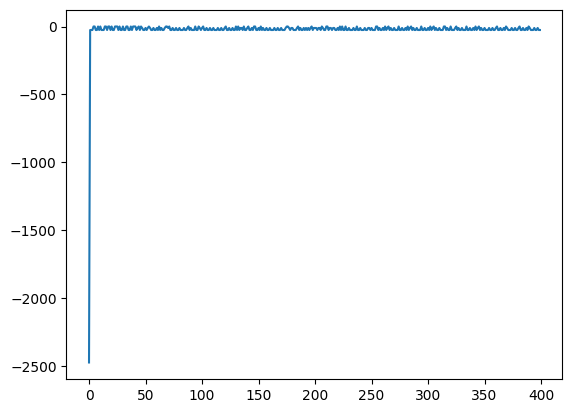

In [41]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n
plt.plot(rewardstest)
# Show the plot\n",
plt.show()

In [34]:
# Play the Game
rewards = []

for episode in range(total_test_episodes):
    total_rewards = 0
    total_penalties = 0
    state = env.reset()
    print('='*40)
    print("[*] Episode", episode)
    print('='*40)

    for step in range(max_steps):
        env.render()
        action = np.argmax(qtable[state, :])
        state, reward, done, info = env.step(action)
        #print(reward)
        """"
        if reward == -10:
            total_penalties += 1
        else:
            total_rewards += reward
        """
        total_rewards += reward
        #print("total time: {}", env.totaltime)
        if done:
            rewards.append(total_rewards)
            print('[*] Score', total_rewards)
            break

env.close()
print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

[*] Episode 0
[*] Score -2475
[*] Episode 1
[*] Score -2475
[*] Episode 2
[*] Score -2475
[*] Episode 3
[*] Score -2475
[*] Episode 4
[*] Score -2475
[*] Episode 5
[*] Score -2475
[*] Episode 6
[*] Score -2475
[*] Episode 7
[*] Score -2475
[*] Episode 8
[*] Score -2475
[*] Episode 9
[*] Score -2475
[*] Episode 10
[*] Score -2475
[*] Episode 11
[*] Score -2475
[*] Episode 12
[*] Score -2475
[*] Episode 13
[*] Score -2475
[*] Episode 14
[*] Score -2475
[*] Episode 15
[*] Score -2475
[*] Episode 16
[*] Score -2475
[*] Episode 17
[*] Score -2475
[*] Episode 18
[*] Score -2475
[*] Episode 19
[*] Score -2475
[*] Episode 20
[*] Score -2475
[*] Episode 21
[*] Score -2475
[*] Episode 22
[*] Score -2475
[*] Episode 23
[*] Score -2475
[*] Episode 24
[*] Score -2475
[*] Episode 25
[*] Score -2475
[*] Episode 26
[*] Score -2475
[*] Episode 27
[*] Score -2475
[*] Episode 28
[*] Score -2475
[*] Episode 29
[*] Score -2475
[*] Episode 30
[*] Score -2475
[*] Episode 31
[*] Score -2475
[*] Episode 32
[*]